# Figure 1B,C: Tracking optogenetically-induced synthetic RhoA wave

In [ ]:
import napari
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from skimage import io, transform
from skimage.util import montage
from arcos4py.tools import remove_image_background, track_events_image
from arcos4py.tools._cleandata import blockwise_median
from napari_timestamper import render_as_rgb
import os

## Function Definitions

In [125]:
def plot_sel_frames(in_im, in_npanels = 2, in_title = "", in_plot_size = (12,8)):
    fig, axarr = plt.subplots(1, 1, figsize=in_plot_size)

    arr_sel_frames = np.linspace(0, len(in_im) - 1, in_npanels).astype(np.int32)
    in_im_sel = in_im[arr_sel_frames]

    im_montage = montage(
        in_im_sel,
        padding_width=10,
        fill=np.max(arr_sel_frames),
        grid_shape=(1, in_im_sel.shape[0]),
    )

    # fig.axis('off')
    axarr.set_axis_off()
    axarr.set_title(in_title)
    for i, frame in enumerate(arr_sel_frames):
        axarr.text(
            10 + i * (im_montage.shape[1] // in_im_sel.shape[0]), 
            10, 
            f"Frame {frame}", 
            color='white', 
            fontsize=12, 
            ha='left', 
            va='top'
        )
    axarr.imshow(im_montage, cmap="gray", vmin=18, vmax=512)

    plt.show()
    
def project_labels(label_image, axis, y_scale=10):
  """
  Projects a label image along a specified axis.

  Args:
    label_image: A NumPy array of shape (t, y, x) representing the label image.
    axis: An integer specifying the axis along which to project (0 for time, 1 for y, 2 for x).
    y_scale: integer how many times the y_axis should be sampled

  Returns:
    A NumPy array of shape (y, t) or (x, t) representing the projected label image.
  """
  if axis >= label_image.ndim:
      raise ValueError("Invalid axis: {}".format(axis))
  
  projection = label_image.max(axis=axis)
  # projection = np.where(projection == 0, np.nan, projection)
  
  return np.repeat(projection, y_scale, axis=0)

# Creating a simplified Python dictionary to map the three integers to their respective Hex color codes
SIMPLE_COLOR_MAPPING = {
    1: '#00A896',  # Blue-Green
    2: '#FF6F61',  # Coral
    3: '#FFCC00',   # Golden Yellow
    4: '#A0E7E5',   # Light Blue
    5: '#FFB5A7',   # Light Coral
    6: '#FFEC99',   # Light Golden Yellow
    7: '#C1F0F6',   # Light Blue-Green
    8: '#FFD3B5',   # Light Salmon
    9: '#FFEEAD',   # Light Goldenrod Yellow
    10: '#A2D5C6',  # Light Sea Green
}

PIXEL_SIZE = 0.21666  # microns

In [126]:
# change the paths to the data and output directories
DATA_DIR = "../../data"
INPUT_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/input-data/raw")
PLOTS_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/output-plots")
OUTPUT_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/output-data")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load images

In [127]:
rGBD = io.imread(os.path.join(INPUT_DIR,'2x_rGBD_dTomato.tif'))
stim = io.imread(os.path.join(INPUT_DIR,'stimulation.tif'))

In [128]:
# Show time-lapse in napari image viewer
viewer = napari.Viewer()
viewer.add_image(rGBD, 
                 name='rGBD', 
                 colormap='gray_r', 
                 blending='additive', 
                 contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
# viewer.add_image(stim, 
#                  name='stim', 
#                  colormap='I Purple', 
#                  blending='minimum', 
#                  contrast_limits=[stim.min()*1, stim.max()*0.25])
viewer.add_image(stim, 
                 name='stim', 
                 colormap='cyan', 
                 blending='additive', 
                 contrast_limits=[64, 22000])

<Image layer 'stim' at 0x415b035b0>

In [129]:
# 4x4 binning for performace; downscaling from 1024x1024 to 256x256
rGBD_binned = blockwise_median(rGBD, (1, 4,4))

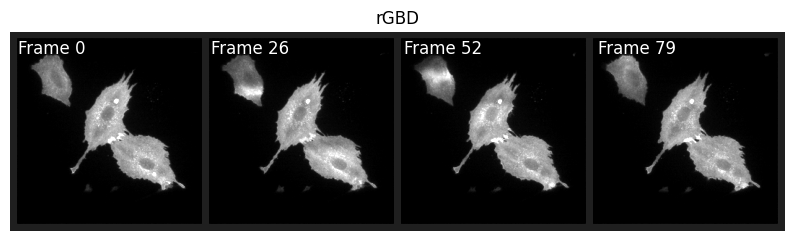

In [130]:
plot_sel_frames(rGBD_binned, 4, "rGBD", (10,3))

In [ ]:
# Remove non-relevant intracellular signal, i.e., pixels that do not comprise the dynamic phenomenon of interest.
rGBD_bckg_rem = remove_image_background(rGBD_binned, 
                                        filter_type='median', 
                                        size=(60,1,1), 
                                        crop_time_axis=False)

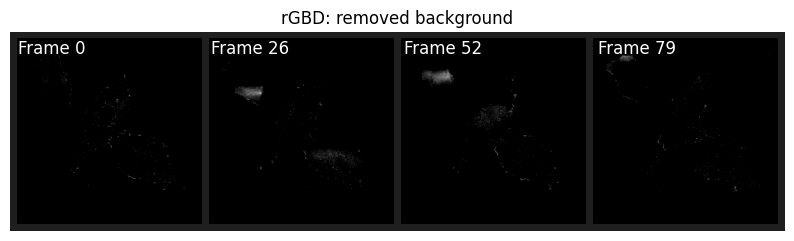

In [132]:
plot_sel_frames(rGBD_bckg_rem, 4, "rGBD: removed background", (10,3))

## Track events

In [ ]:
binary_img = rGBD_bckg_rem > 20

In [140]:
events = track_events_image(
    binary_img, 
    eps=8, 
    min_clustersize=150,)

100%|██████████| 80/80 [00:00<00:00, 113.22it/s]


In [60]:
# use skimage rescale to get the events in the original image size
events_upscaled = transform.rescale(events.astype(int), 
                                    (1, 4, 4), 
                                    order=0, 
                                    preserve_range=True, 
                                    mode='constant')

In [69]:
viewer.add_labels(events_upscaled, name='events', colormap=SIMPLE_COLOR_MAPPING)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/napari/utils/colormaps/colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<Labels layer 'events' at 0x37e2cbc40>

## Render sample images

### Snapshots

In [122]:
# Display in napari, mix images and get the final image to save
arr_sel_frames = np.linspace(0, 54, 4, dtype=int)

rgb_events = []
rgb_rGBD_stim = []
viewer.layers['rGBD'].visible = True
viewer.layers['stim'].visible = True
viewer.layers['events'].visible = True
for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['events'].visible = False

for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_rGBD_stim.append(render_as_rgb(viewer, upsample_factor=1))

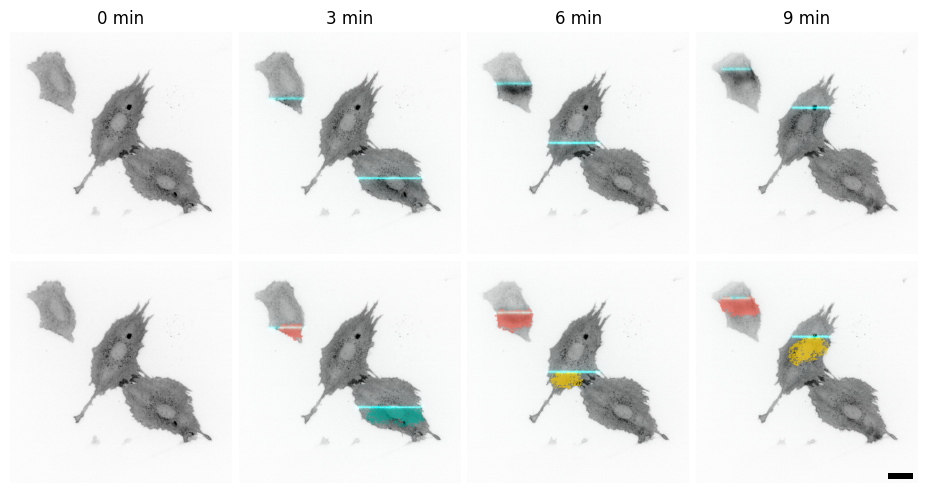

In [123]:
# Plot and save here
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(2,4, figsize=(10,5))

for idx, val in enumerate(arr_sel_frames):
    ax[0, idx].imshow(rgb_rGBD_stim[idx])
    ax[0, idx].axis('off')
    ax[0, idx].set_title(f'{val*1/6:.0f} min')

for idx, val in enumerate(arr_sel_frames):
    ax[1, idx].imshow(rgb_events[idx])
    ax[1, idx].axis('off')
    if val == arr_sel_frames[-1]:
        scalebar = ScaleBar(PIXEL_SIZE, "um", 
                            length_fraction=0.2, 
                            location='lower right', 
                            box_alpha=0, 
                            scale_loc="none", 
                            width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-4)
plt.savefig(os.path.join(PLOTS_DIR,'montage-sel-frames.svg'), dpi=600)

### Detrended active RhoA and tracked events

In [86]:
# Display in napari, mix images and get the final image to save
viewer_projection = napari.Viewer()

# Perform maximum projection along the x axis, axis=2
viewer_projection.add_image(project_labels(transform.rescale(rGBD_bckg_rem, 
                                                             (1,4,4), 
                                                             mode='constant'), 
                                            axis=1), 
                            name='rGBD_detrended',
                            colormap='gray_r',
                            contrast_limits=[40, 300])

l = viewer_projection.add_labels(project_labels(events_upscaled,
                                                axis=1), 
                                 name='events',
                                 opacity=1,
                                 colormap=SIMPLE_COLOR_MAPPING)
l.contour = 20

noodles_rbg_rGBD = render_as_rgb(viewer_projection, upsample_factor=1)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/napari/utils/colormaps/colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


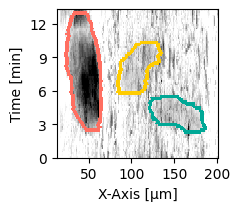

In [121]:
# Plot here and save
x_ticks_um = np.arange(50,250,50)
x_ticks_px = x_ticks_um/PIXEL_SIZE

y_ticks_min = np.arange(0,15,3)
y_ticks_s = y_ticks_min*60

fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg_rGBD, cmap='tab20', vmin=1, vmax=3, interpolation='none')

ax.set_xlim(60, 930)
ax.invert_yaxis()
ax.set_xticks(x_ticks_px, labels=x_ticks_um)
ax.set_yticks(y_ticks_s, labels=y_ticks_min)
ax.set_xlabel('X-Axis [μm]')
ax.set_ylabel('Time [min]')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'noodles_bg_removed.svg'), dpi=600)

### Active RhoA and stimulation

`max_rGBD` returns np.array filled with 255. Fix!

In [109]:
# Display in napari, mix images and get the final image to save

viewer_projection = napari.Viewer()
viewer_projection.add_image(project_labels(rGBD, axis=1), 
                            name='rGBD',
                            colormap='gray_r')

viewer_projection.add_image(project_labels(stim, axis=1), 
                            name='stim',
                            colormap='cyan', 
                            blending='additive')
#viewer_projection.add_image(project_labels(stim, 2), colormap='I Purple', blending='minimum')
max_rGBD = render_as_rgb(viewer_projection, upsample_factor=1)
#viewer_projection.close()

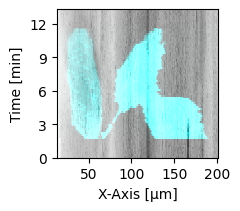

In [120]:
# Plot here and save
x_ticks_um = np.arange(50,250,50)
x_ticks_px = x_ticks_um/PIXEL_SIZE

y_ticks_min = np.arange(0,15,3)
y_ticks_s = y_ticks_min*60

fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(max_rGBD, interpolation='none')

ax.set_xlim(60, 930)
ax.invert_yaxis()
ax.set_xticks(x_ticks_px, labels=x_ticks_um)
ax.set_yticks(y_ticks_s, labels=y_ticks_min)
ax.set_xlabel('X-Axis [μm]')
ax.set_ylabel('Time [min]')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'raw_max_proj.svg'), dpi=600)

### Save the movie

In [ ]:
_stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR, '/stack.tif'), _stack)

### Export RGB tifs

In [ ]:
# upsample binary, detrended image to original size
binary_upscaled = transform.rescale(binary_img.astype(int), (1, 4, 4), order=0, preserve_range=True, mode='constant')
rGBD_bckg_rem_upscaled = transform.rescale(rGBD_bckg_rem, (1, 4, 4), order=0, preserve_range=True, mode='constant')


In [ ]:
rgb_tiff_viewer = napari.Viewer()
l1 = rgb_tiff_viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
l2 = rgb_tiff_viewer.add_image(stim, name='stim', colormap='I Purple', blending='minimum', contrast_limits=[stim.min()*1, stim.max()*0.25])
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_stim_rgbd.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)
rgb_tiff_viewer.layers.remove(l2)

l1 = rgb_tiff_viewer.add_image(rGBD_bckg_rem_upscaled, name='detrended rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.25])
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_detrended_rgbd.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)

l1 = rgb_tiff_viewer.add_image(binary_upscaled, name='binary', colormap='gray_r', blending='additive')
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_binary.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)

l1 = rgb_tiff_viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
l2 = rgb_tiff_viewer.add_labels(events_upscaled, name='events', colormap=SIMPLE_COLOR_MAPPING)
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)

io.imsave(os.path.join(OUTPUT_DIR,'rgb_events.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)
rgb_tiff_viewer.layers.remove(l2)

rgb_tiff_viewer.close()


c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(
